In [63]:
import json
from pathlib import Path
import pandas as pd 
import tensorflow as tf 
import numpy as np
from tensorflow.data import Dataset 
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D

#### Setup and Dataset

In [2]:
with open("../config.json") as file:
    config = json.load(file)
 
aptos2019_path = Path(config["dataset"]["aptos_2019"]["balanced_resized"])
models_trained_path = Path(config["models_trained"])

In [3]:
csv = pd.read_csv(aptos2019_path / "labels.csv")
images_path = str(aptos2019_path / "images")

num_class = 5
def name2image_class2onehot(tensor):
    # Loading and processing image
    image_name = "/" + tensor["img_name"] + ".png"
    image_path = images_path + image_name
    image_file = tf.io.read_file(image_path)
    image_file = tf.io.decode_png(image_file,channels=3)
    image_file = tf.cast(image_file,tf.float32)
    image_file = tf.image.resize(image_file,[224,224])
    image_file /= 255.0
    # onehotting the class 
    onehot_class = tf.one_hot(tensor["class"], depth = num_class)
    
    return (image_file, onehot_class)

tf.random.set_seed(342)
aptos2019_dataset = (Dataset
                     .from_tensor_slices(dict(csv))
                     .shuffle(len(csv))
                     .map(name2image_class2onehot))

# Selecting sizes of train, val and test dataset
dataset_size = dict() 
dataset_size["train"] = 0.7 
dataset_size["val"]   = 0.2
dataset_size["test"]  = 0.1

# creating train, test, val datasets
for key in dataset_size:
    dataset_size[key] = int(dataset_size[key] * len(aptos2019_dataset))
dataset = dict()
dataset["train"] = aptos2019_dataset.take(dataset_size["train"]) 
dataset["val"] = aptos2019_dataset.skip(dataset_size["train"]).take(dataset_size["val"])
dataset["test"] = aptos2019_dataset.skip(dataset_size["train"] + dataset_size["val"]).take(dataset_size["test"]) 

# batching the splits
batch_size = 8
dataset["train"] = dataset["train"].batch(batch_size)
dataset["val"] = dataset["val"].batch(batch_size)
#  dataset["test"] = dataset["test"].batch(batch_size)

print("Splitting sizes:")
for key in dataset_size:
    print(f"- {key} size : {dataset_size[key]}")

# example of a tensor from train set
print("\nExample Tensor:")
for tensor in dataset["train"].take(1):
    print("Batched Input shape:", tensor[0].shape)
    print("Batched One-hot Tensor Shape:", tensor[1].shape)
    print("One-hot Tensor numpy", tensor[1].numpy()[0])

I0000 00:00:1734367677.778382    1747 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Splitting sizes:
- train size : 12959
- val size : 3702
- test size : 1851

Example Tensor:
Batched Input shape: (8, 224, 224, 3)
Batched One-hot Tensor Shape: (8, 5)
One-hot Tensor numpy [0. 0. 0. 0. 1.]


2024-12-16 16:47:59.461236: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Grad-CAM on trained CNN-1 Experiment:

In [4]:
model_cnn_1 = load_model(models_trained_path / "cnn_1.keras")
model_cnn_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,455,297 (39.88 MB)

 Trainable params: 3,485,013 (13.29 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 6,970,028 (26.59 MB)

In [91]:
# Loading one image tensor
x = tf.Variable(dataset["test"].batch(1).__iter__().next()[0])

In [20]:
with tf.GradientTape() as tape:
    y = model_cnn_1(x)
gradients = tape.gradient(y,model_cnn_1.get_layer("conv2d_4").trainable_variables)    

In [72]:
a = np.sum(gradients[0],axis=(0,1,2))

(128,)

In [85]:
A = model_cnn_1.get_layer("conv2d_4").output
print(type(A), A.shape)

<class 'keras.src.backend.common.keras_tensor.KerasTensor'> (None, 14, 14, 128)


In [88]:
from tensorflow.keras import Model
conv_out = Model(inputs = model_cnn_1.inputs, outputs = A)

In [95]:
A = conv_out(x)

/home/karthikgpu/tf_gpu/tf218/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(


(14, 14)
(224, 224)


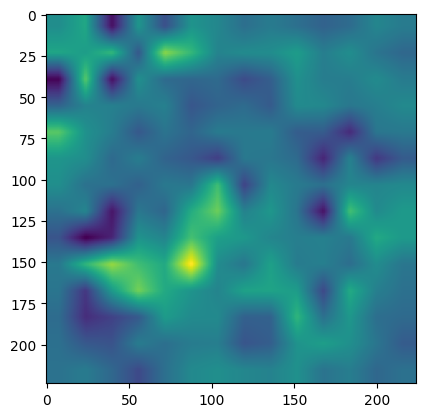

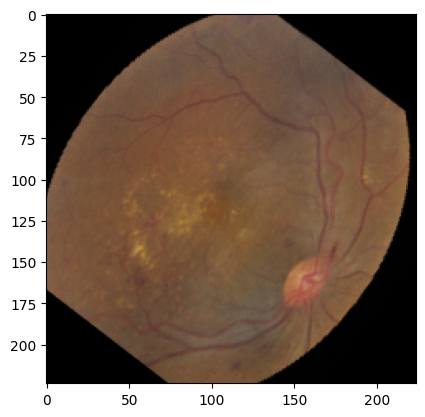

In [141]:
import cv2
SUM = np.zeros((14,14))
for i in range(128):
    A_i = A[:,:,:,i]
    A_a = a[i] * A_i
    SUM += A_a
SUM = SUM.numpy()[0]
import matplotlib.pyplot as plt 
print(SUM.shape)
SUM = cv2.resize(SUM,(224,224), interpolation=cv2.INTER_LINEAR)
print(SUM.shape)
plt.imshow(SUM)
plt.show()
plt.imshow(x[0])

In [135]:
SUM[0].shape

(14, 14)